# Evasion Attacks

In this tutorial you will try out two evasion attacks mentioned during the lecture. The first part of the notebook will guide you through the implementation of the *Fast Gradient Sign Method (FGSM)*. We will show you how to implement it yourself and how you can use an existing library to get the same resutls. The final part of this notebook focuses on implementing *Projected Gradient Descent (PGD)*. You will need to implement it yourself. In both cases we will make use of the MNIST dataset and a simple convolutional neural network.

## Imports

Lets first import important packages. This includes the package [torchattacks](https://adversarial-attacks-pytorch.readthedocs.io/en/latest/attacks.html), a PyTorch library that provides adversarial attacks. 

In [1]:
# For plotting and computing
import matplotlib.pyplot as plt
import numpy as np
import random

# PyTorch packages
import torch
from torch import optim
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.functional import cross_entropy, softmax
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# This will install torchattacks if not yet present
#!pip install torchattacks
import torchattacks
import torchvision
import torchvision.transforms as transforms

# For Load Bar
from tqdm import tqdm

## Device

We also set the device variable so that we can easily switch from using cpu to gpu (if available).

In [2]:
# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


## Random Seed

Execute the code snippet below to set the random seed. This will ensure that you can reproduce results over multiple tries. So anyone who re-runs your code will get the exact same outputs.

For example: we will set shuffle to True and so the training loader will randomly shuffle the data over multiple runs. If you make changes to your code because training is not going well, then setting the random seed ensures that you can perform the training with the same samples as in previous tries. 

In [3]:
# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        
setup_seed(3131)

## Data

We already introduced the MNIST dataset in a previous tutorial where we trained and tested a MLP and CNN on it. It is an illustrative dataset that is also not to big and so training a new model does not take too much time. We make use of PyTorch's `DataLoader` class to create objects that we can use to sample training and test data using batches of size 128.

However, we set the batch size for the test loader to 1. This is uncommon, but it is needed as we will loop over all test samples individual to compute the accuracy of the model when the attack has been applied.

In [4]:
n_classes = 10
img_size  = 28
channel   = 1
num_workers = 0
train_size = round((5/6),2)
val_size = round(1.0-train_size,2)

# A method to ensure reproducibility
def _init_fn(worker_id):
    np.random.seed(int(seed))

train_set = torchvision.datasets.MNIST(root='d:\Datasets', transform=transforms.ToTensor(), download=True, train=True)

train_set, val_set = torch.utils.data.random_split(train_set, [int(len(train_set)*train_size), int(len(train_set)*val_size)])
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)

test_set = torchvision.datasets.MNIST(root='d:\Datasets', transform=transforms.ToTensor(), download=True, train=False)
test_loader = DataLoader(test_set,  batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=True, worker_init_fn=_init_fn)

## Neural Network

Here we provide a basic CNN network that we will train on the MNIST dataset and then attack using FGSM and PGD. Feel free to alter the network.

In [5]:
class CNN(Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.3)
        
        self.conv2 = nn.Conv2d(128, 224, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(224*4*4, 64)
        self.drop3 = nn.Dropout(p=0.4)
        
        self.fc4 = nn.Linear(64, 32)
        self.drop4 = nn.Dropout(p=0.4)
        
        self.fc5 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)
   
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = x.view(-1,224*4*4)
        x = self.drop3(F.relu(self.fc3(x)))
        x = self.drop4(F.relu(self.fc4(x)))
        x = self.softmax(self.fc5(x))
        return x

We also define an optimizer and loss function with hyper parameter settings for training. Again feel free to make changes to these settings, but for the purpose of learning to work with FGSM and PGD you can use these pre-defined settings.

In [6]:
model = CNN().to(device)
optimizer = optim.Adadelta(model.parameters(),lr=1.0)
criterion = torch.nn.CrossEntropyLoss()

## Training

To train our own model we use some of the methods we provided in the previous tutorial on model training. 
Below you find the following methods:

- `accuracy(predictions,labels)`: Takes the two tensors `predictions` and `labels` as input and computes the total number of correct predictions divided by the total number of predictions. This Float value is returned.
- `log_training(batch_idx, running_loss, running_acc)`: Takes Integer `batch_idx` which specifies the batch index, Float `running_loss` which represents the loss at that moment of the training, Float `running_acc` which represents the accuracy at that moment of the training. It simply prints these values.
- `training_step(model, batch, criterion)`: Takes PyTorch `model`, Tuple `batch` which contains image(s) and label(s), Torch Loss Function `criterion`. This method uses these values to generate predictions, calculate the loss and also the accuracy. It then returns both Float loss and  Float accuracy.
- `validation_step(model, batch, criterion)`: Takes PyTorch `model`, Tuple `batch` which contains image(s) and label(s), Torch Loss Function `criterion`. This method uses these values to generate predictions, calculate the loss and also the accuracy. It then returns both Float loss and  Float accuracy inside a Dict.
- `validate(model, val_loader, criterion)`: Takes PyTorch `model`, PyTorch DataLoader `val_loader`, Torch Loss Function `criterion`. This method goes over all batches in the val_loader and performs the validation_step. After this it computes the total epoch loss and accuracy by taking the mean over all batch values. These both Float values are returned inside a Dict.
- `epoch_end(result)`: Takes Dict `result` which holds the epoch loss and epoch accuracy values. Both values are simply printed.
- `train(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=10)`: Takes PyTorch `model`, String `model_name`, PyTorch Loss function `criterion`, PyTorch optimizer function `optimizer`, PyTorch DataLoader `train_loader`, PyTorch DataLoader `val_loader`, Integer `num_epochs`. Performs training of model. Model name is used to save the trained model. Loops over all batches in train loader and val loader. Num epochs determines for how many epochs, default is set to 10. Returns `history` which contains all epochs losses and accuracies.
  

In [7]:
# Method to compute accuracy
def accuracy(predictions,labels):
    _, preds = torch.max(predictions, dim=1)
    return (torch.tensor(torch.sum(preds == labels).item() / len(preds)))

# Method to log training / running loss and accuracy
def log_training(batch_idx, running_loss, running_acc):
    print(f"Batch: {batch_idx}, Running Loss: {running_loss / (batch_idx + 1):.2f}, Running Accuracy: {running_acc:.2f}")

def training_step(model, batch, criterion):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    # Calculate loss
    loss = criterion(predictions, labels)
    # Calculate accuracy
    acc = accuracy(predictions, labels)
    return loss, acc

def validation_step(model, batch, criterion):
    # Prepare batch data
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    # Generate predictions
    predictions = model(images)
    # Calculate loss
    loss = criterion(predictions, labels)
    # Calculate Accuracy
    acc = accuracy(predictions, labels)
    return {'val_loss': loss, 'val_acc': acc}

def validate(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        outputs = [validation_step(model, batch, criterion) for batch in val_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

# Method to log epoch loss and accuracy
def epoch_end(result):
    print(f"val_loss: {result['val_loss']:.2f}, val_acc: {result['val_acc']:.2f}\n")

def train(model, model_name, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    history = []
    for epoch in range(num_epochs):
        print("Epoch: ", epoch+1)
        running_loss = 0
        # Training Phase
        for batch_idx, batch in enumerate(train_loader):
            # Calculate Loss
            loss, running_acc = training_step(model, batch, criterion)
            # Compute Gradients
            loss.backward()
            # Update weights
            optimizer.step()
            # Reset Gradients
            optimizer.zero_grad()

            # running loss and accuracy
            running_loss += loss.item()
            if batch_idx % 50 == 0 and batch_idx != 0:
                log_training(batch_idx, running_loss, running_acc)

        # Validation Phase
        result = validate(model, val_loader, criterion)
        epoch_end(result)
        history.append(result)

    # Save checkpoint file
    torch.save(model.state_dict(), f"{model_name}.pth")
    return history

Now train the model for later use:

In [8]:
train_history = train(model,"cnn_model",criterion,optimizer,train_loader,val_loader,num_epochs=14)

Epoch:  1
Batch: 50, Running Loss: 2.27, Running Accuracy: 0.21
Batch: 100, Running Loss: 2.12, Running Accuracy: 0.53
Batch: 150, Running Loss: 2.02, Running Accuracy: 0.73
Batch: 200, Running Loss: 1.95, Running Accuracy: 0.72
Batch: 250, Running Loss: 1.90, Running Accuracy: 0.78
Batch: 300, Running Loss: 1.86, Running Accuracy: 0.88
Batch: 350, Running Loss: 1.83, Running Accuracy: 0.88
val_loss: 1.61, val_acc: 0.85

Epoch:  2
Batch: 50, Running Loss: 1.60, Running Accuracy: 0.87
Batch: 100, Running Loss: 1.59, Running Accuracy: 0.95
Batch: 150, Running Loss: 1.56, Running Accuracy: 0.93
Batch: 200, Running Loss: 1.55, Running Accuracy: 0.95
Batch: 250, Running Loss: 1.54, Running Accuracy: 0.98
Batch: 300, Running Loss: 1.53, Running Accuracy: 0.92
Batch: 350, Running Loss: 1.53, Running Accuracy: 0.97
val_loss: 1.49, val_acc: 0.97

Epoch:  3
Batch: 50, Running Loss: 1.49, Running Accuracy: 0.98
Batch: 100, Running Loss: 1.49, Running Accuracy: 0.96
Batch: 150, Running Loss: 1.49,

## FGSM

Now that we constructed and trained a basic CNN we will start with our first evasion attack: FGSM. Below you see the panda example also shared during the lecture. Here we have $x$, which is the original image, and we add $\epsilon \cdot sign(\bigtriangledown_x \mathcal{J}(\theta,x, y))$ to get the adversarial image $x'$. Where $y$ is the ground truth label for $x$, $\theta$ represents the model parameters, and $\mathcal{J}(\theta,x, y)$ is the loss that is used to train the network. To calculate $\bigtriangledown_x \mathcal{J}(\theta,x, y)$, the attack backpropagates the gradient back to the input data. Then it uses $\epsilon$ to adjust the input data by a small step in the direction (i.e. $sign(\bigtriangledown_x \mathcal{J}(\theta,x, y))$) that maximizes the loss. All together:

$$x' = x + \epsilon \cdot sign(\bigtriangledown_x \mathcal{J}(\theta,x, y))$$

![FGSM](images/fgsm_panda_image.png)

### Epsilon

Just like in the official [PyTorch FGSM tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html), we define a list of epsilon values to use during the attack. It includes 0 to represent the model performance on the original test set and we build up to higher values to see what effect this has on the accuracy and on the images. The idea is that the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is $[0,1]$, no epsilon value should exceed 1.

In [12]:
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

### Visualization perturbation FGSM

Let's take a batch of images from MNIST test set and plot them before we use FGSM on them and after:

In [9]:
def plot_images(images,labels):
    np_images = images.detach().cpu().numpy()

    # making sure we can view the images
    np_images = np_images*255
    np_images = [image.astype(np.uint8).reshape((28, 28, 1)) for image in np_images]

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(np_images[idx], cmap='gray')
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(labels[idx].item()))
        
def plot_image(image,label):
    figure = plt.figure(figsize=(4, 4))
    plt.imshow(image[0].cpu(), cmap='gray')
    plt.title(str(label.item()))

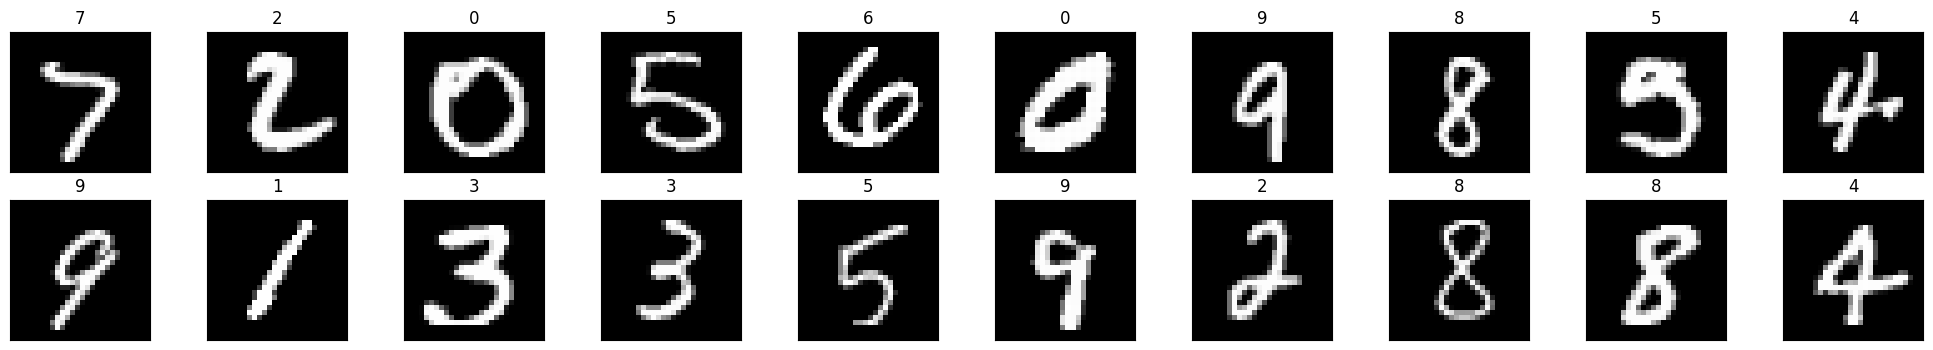

In [10]:
# obtain one batch of training images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)
plot_images(images,labels)

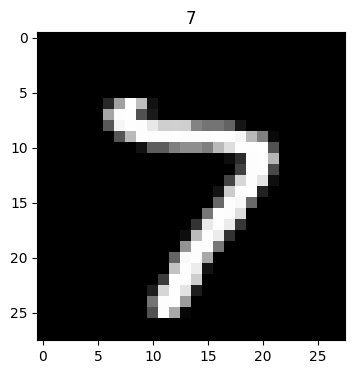

In [11]:
plot_image(images[0],labels[0])

Now lets compute the adverserial images for this batch using FGSM. 

Below we provide you a `FGSM` class which you can use to create a FGSM attack object. The object can be created providing a (trained) model, epsilon value between 0.0 and 1.0 (default set to 0.3), loss function (default set to Cross Entropy) and the device (default set to cpu). 

The `forward()` method of the `FGSM` class can be used to create adversarial images. It takes in images and corresponding labels. It then uses the trained model to generate predictions and compute the loss. Using [`torch.autograd.grad()`](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) it computes the sum of gradients of the predictions with respect to the inputs. Using this sum of gradients and the epsilon value we can then create adversarial image of the original images.

In [13]:
class FGSM(nn.Module):
    
    def __init__(self, model, eps=0.3, criterion=nn.CrossEntropyLoss(),device='cpu'):
        super().__init__()
        self.model = model
        self.eps = eps
        self.criterion = criterion
        self.device = device
        
    def forward(self, images, labels):
        # Prepare data
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        # Specify that the gradients need to be computed
        images.requires_grad = True
        # Generate predictions
        predictions = self.model(images)
        # Compute Loss
        loss = self.criterion(predictions,labels)
        # Calculate the derivative of the loss w.r.t. the original image
        grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
        # Compute the adversarial images
        adv_images = images + self.eps*grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()
        return adv_images

Execute the code cell below to create a FGSM attack object.

In [14]:
attack = FGSM(model=model,eps=0.3,criterion=criterion,device=device)

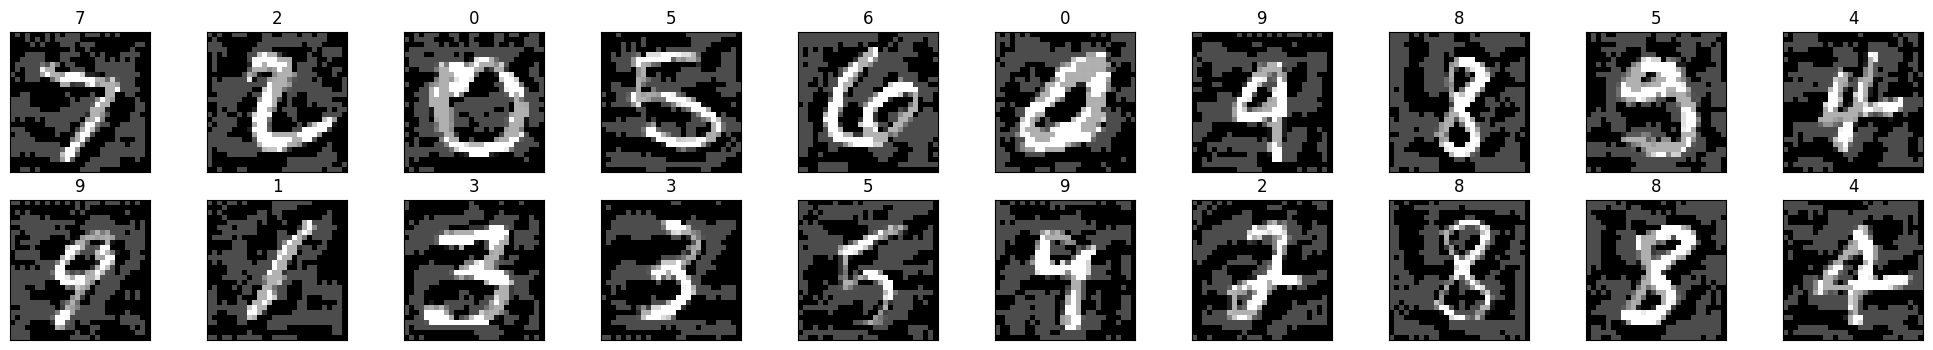

In [15]:
adv_images = attack(images,labels)
plot_images(adv_images,labels)

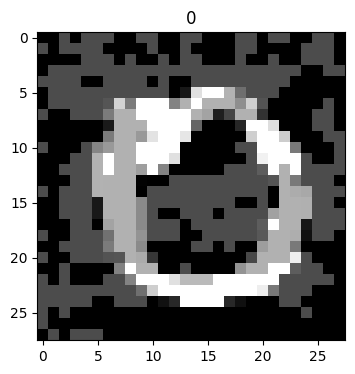

In [16]:
plot_image(adv_images[2],labels[2])

As you can see from the last two plots is that using $\epsilon = 0.3$ causes very noticeable perturbations. The changes to the original images can be spotted quite easily. Lets now check what is the effect on the performance of the used model.

### Performance

For the purpose of checking the effectiveness of the FGSM attack on the performance of our model we provide you with the `test` method below. This method takes in the `model`, `test_loader` and `epsilon` value. This way we can try out different epsilon values to see how this affects the attack.

In [17]:
def create_perturbed_image(image, epsilon):
    # Collect gradient
    image_grad = image.grad.data
        
    # Collect the element-wise sign of the gradient
    sign_image_grad = image_grad.sign()
        
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_image_grad
        
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

def save_example(adv_examples, perturbed_image, init_pred, final_pred):
    adv_ex = perturbed_image.squeeze().detach().cpu().numpy()
    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

def attack_test(model, criterion, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []
    
    # Loop over all samples in test set
    for image, label in test_loader:
        
        # Send the data and label to the device
        image, label = image.to(device), label.to(device)
        
        # Set requires_grad attribute to True. Important for Attack
        image.requires_grad = True
        
        # Forward pass the data through the model
        prediction = model(image)
        
        # Get the index of the max log-probability
        _, init_pred = prediction.max(1, keepdim=True)
        
        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != label.item():
            continue
            
        # Calculate the loss
        loss = criterion(prediction, label)
        
        # Zero all existing gradients
        model.zero_grad()
        
        # Calculate gradients of model in backward pass
        loss.backward()

        # Compute pertrubed image
        perturbed_image = create_perturbed_image(image, epsilon)
        
        # Re-classify the perturbed image
        new_prediction = model(perturbed_image)
        
         # Get the index of the max log-probability
        _, final_pred = new_prediction.max(1, keepdim=True)
        
        # Check for success
        if final_pred.item() == label.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                save_example(adv_examples, perturbed_image, init_pred, final_pred)
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                save_example(adv_examples, perturbed_image, init_pred, final_pred)
    
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [18]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attack_test(model, criterion, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9913 / 10000 = 0.9913
Epsilon: 0.05	Test Accuracy = 9623 / 10000 = 0.9623
Epsilon: 0.1	Test Accuracy = 8985 / 10000 = 0.8985
Epsilon: 0.15	Test Accuracy = 8066 / 10000 = 0.8066
Epsilon: 0.2	Test Accuracy = 6803 / 10000 = 0.6803
Epsilon: 0.25	Test Accuracy = 5397 / 10000 = 0.5397
Epsilon: 0.3	Test Accuracy = 4094 / 10000 = 0.4094


### Accuracy vs Epsilon

Like we mentioned earlier as the epsilon increases we expect the test accuracy to decrease. The reason is that with a larger epsilon we take a larger step in the direction that will maximize the loss. Notice the trend in the curve is not linear even though the epsilon values are linearly spaced.

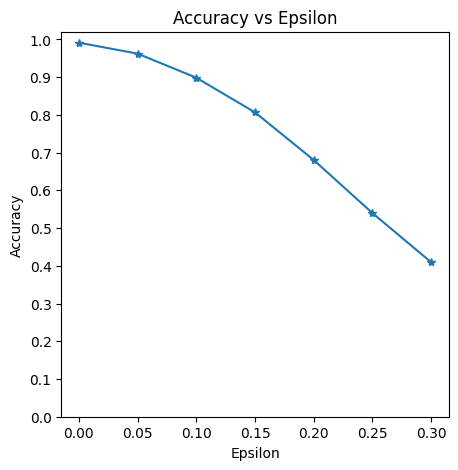

In [19]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

While a higher epsilon might decrease the accuracy, the plots below also show that the perturbations become more easily perceptible. So an attacker should consider a tradeoff between accuracy degredation and perceptibility of the perturbations. The plots below show examples of successfull adversarial examples at each epsilon value. Each row of the plot shows a different epsilon value. The first row is the $\epsilon = 0$ examples which represent the original "clean" images with no perturbation. The title of each image shows the "original classification -> adversarial classification". Notice, the perturbations start to become evidant from around $\epsilon = 0.15$ and are quite evident at $\epsilon = 0.3$. However, in all cases humans are still capable of identifying the correct class despite the added noise.

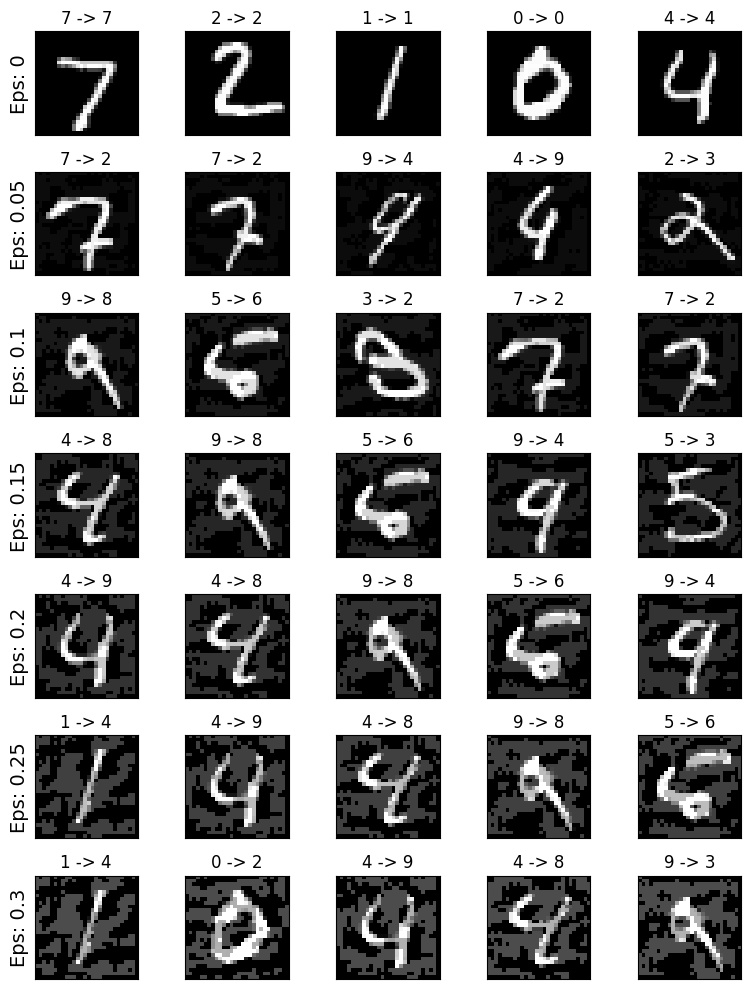

In [20]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

### Attack Evaluation

To evaluate the success of your evasion attack you could measure the model's accuracy. First you test your model using clean samples. Then you test your model using your evasion attack and a specific epsilon value. The drop in accuracy rate is the measure of success of your attack. The code snippet below shows you how this is done. We can reuse the `attack_test()` method from earlier using `epsilon=0` to test the clean model on only clean samples. 

In [21]:
# clean test
clean_acc, _ = attack_test(model, criterion, device, test_loader, epsilon=0.0)

# attack test
attack_acc, _ = attack_test(model, criterion, device, test_loader,epsilon=0.3)

Epsilon: 0.0	Test Accuracy = 9913 / 10000 = 0.9913
Epsilon: 0.3	Test Accuracy = 4094 / 10000 = 0.4094


In [22]:
acc_drop = round(attack_acc-clean_acc,2)
print(f"Accuracy Drop: {acc_drop}")

Accuracy Drop: -0.58


You can also use the `test()` method below to test the accuracy of your model without attack:

In [23]:
def test(model, criterion, optimizer, test_loader):
    # Execute Testing
    test_loss = []
    test_acc = []
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_loader):
            # Prepare batch data
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            # Generate predictions
            predictions = model(images)
            # Calculate loss
            batch_test_loss = criterion(predictions, labels)
            # Calculate accuracy
            batch_test_acc = accuracy(predictions, labels)
            # Store batch results
            test_loss.append(batch_test_loss)
            test_acc.append(batch_test_acc)
    
    # Display Results
    print("Test Loss: ", round(torch.stack(test_loss).mean().item(),2))
    print("Test Accuracy: ", round(torch.stack(test_acc).mean().item()*100.0,2))
    return round(torch.stack(test_acc).mean().item(),4)

In [24]:
clean_acc = test(model, criterion, optimizer, test_loader)

100%|██████████| 10000/10000 [00:19<00:00, 516.02it/s]

Test Loss:  1.47
Test Accuracy:  99.13


In [25]:
acc_drop = round(attack_acc-clean_acc,2)
print(f"Accuracy Drop: {acc_drop}")

Accuracy Drop: -0.58


If you would do this for all epsilon you could then plot the accuracy drops in a bar plot:

In [26]:
acc_drops = [round(x - accuracies[0],4) for x in accuracies[1:]]

<Figure size 500x500 with 0 Axes>

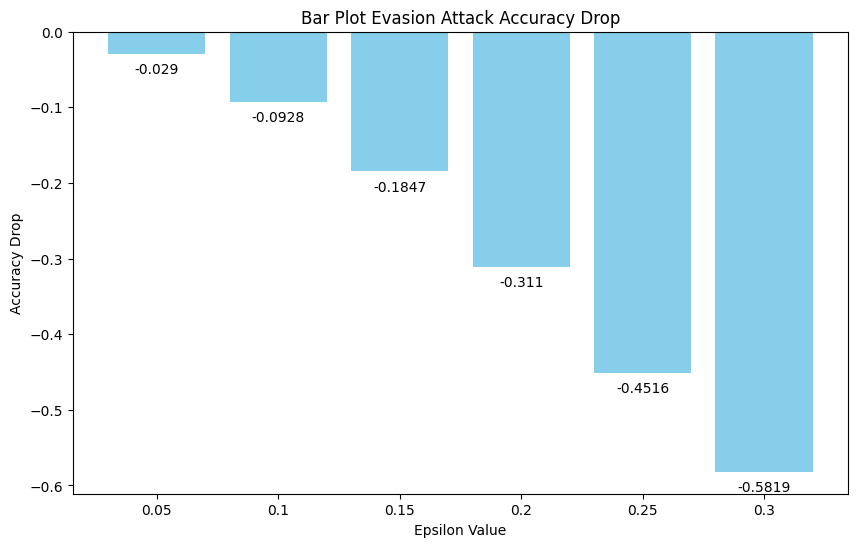

In [27]:
plt.figure(figsize=(5,5))
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(acc_drops)), acc_drops, color='skyblue')

# Adding the text inside the bars for each value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.03, round(yval, 4), ha='center', va='bottom')

plt.xlabel('Epsilon Value')
plt.ylabel('Accuracy Drop')
plt.title('Bar Plot Evasion Attack Accuracy Drop')
plt.xticks(range(len(acc_drops)), [str(eps) for eps in epsilons[1:]])  # Set x-ticks to be the indices
plt.show()

### Torchattacks

Instead of implementing the FGSM attack yourself, you can also make use of PyTorch `torchattack` library that includes many predefined attacks. We will show you that you will get the same result using our earlier implementation of the FGSM attack and the `torchattack` version. First we define a `test` method to show the accuracy of the model using the original images and then we define a `adv_test` method to show the accuracy using FGSM adversarial images. 

In [28]:
def test(model, test_loader):
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
            images, labels = images.to(device), labels.to(device)
            # Evaluation
            predictions = model(images).detach()

            # Test
            _, predicted = torch.max(predictions, dim=1)
            total += labels.numel()
            correct += (predicted == labels).sum().item() 


        print('[Plain/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total

In [29]:
test(model, test_loader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 10000/10000 [00:20<00:00, 476.62it/s]

[Plain/Test] Acc: 99.130


99.13

In [30]:
def adv_test(attack, model, test_loader):
    correct = 0
    total = 0

    model.eval()
    print('\n\n[Plain/Test] Under Testing ... Please Wait')
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader)):
        images, labels = images.to(device), labels.to(device)
        # dataloader parsing and generate adversarial examples
        adv_inputs = attack(images, labels)
        # Evaluation
        predictions = model(adv_inputs).detach()

        # Test
        _, predicted = torch.max(predictions, dim=1)
        total += labels.numel()
        correct += (predicted == labels).sum().item() 

        
    print('[Plain/Test] Acc: {:.3f}'.format(100.*correct / total))
    return 100.*correct / total

In [31]:
adv_test(attack,model,test_loader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 10000/10000 [00:43<00:00, 231.69it/s]

[Plain/Test] Acc: 40.940


40.94

In [32]:
attack = torchattacks.FGSM(model, eps=0.3)

In [33]:
adv_test(attack,model,test_loader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 10000/10000 [00:44<00:00, 225.41it/s]

[Plain/Test] Acc: 40.940


40.94

As you can see both lower the performance of our model to the same accuracy and with the `torchattacks` library you only need to provide a pre-trained model and an epsilon value to define the FGSM attack.

## PGD

Now as an exercise you will implement the PGD attack yourself. Complete the code below using information you can find in this notebook, from the lecture slides and in other sources.

PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083](https://arxiv.org/abs/1706.06083)

Distance Measure : $\ell_\infty$

Arguments:
- model (nn.Module): model to attack.
- eps (float): maximum perturbation. (Default: 0.3)
- alpha (float): step size. (Default: 2/255)
- steps (int): number of steps. (Default: 10)
- random_start (bool): using random initialization of delta. (Default: True)

Shapes:
- images: $(N, C, H, W)$ where $N$ = number of batches, $C$ = number of channels, $H$ = height and $W$ = width. It must have a range $[0, 1]$.
- labels: $(N)$ where each value $y_i$ is $0 \leq y_i \leq$ number of labels.
- output: $(N, C, H, W)$.


$$x_{t+1} = Clip_{x+S} (x_{t} + \alpha sign(\bigtriangledown_x \mathcal{J}_{\theta}(x, l)))$$

*Note:* this formula is taken from the original paper where they use $x$ instead of $x_{t}$ inside $sign(\cdot)$. This is a generic representation.

For your implementation below you should consider:


$$x_{t+1} = Clip_{x+S} (x_{t} + \alpha sign(\bigtriangledown_x \mathcal{J}_{\theta}(x_{t}, l)))$$

Where $Clip_{x+S}$, means that you project $x_{t}$ back when it went out of the limitation ($x+S$). 

Consider the following:

1) When you update the adversarial images inside the loop with grad you do not want the adversarial images to be too different, so PGD projects it by back so that the perturbation (adv_image - original_image) should be in the range of $[-\epsilon,\epsilon]$.
2) After you add this perturbation (the variable delta in PGD), you want to make sure it is a real image. So you should project it back such that the image is in range $[0,1]$.

In [37]:
import torch
import torch.nn as nn

class PGD(nn.Module):
    
    def __init__(self, model, eps=8/255,
                 alpha=2/255, steps=10, random_start=True,loss=nn.CrossEntropyLoss(),device='cpu'):
        super().__init__()
        self.model = model
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.loss = loss
        self.device = device

    def forward(self, images, labels):
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        adv_images = images.clone().detach().to(self.device)

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()
            

        # Implementation of PGD
        
        # PGD is a multi-step version of FGSM
        for _ in range(self.steps):
            # Prepare images and labels
            images = images.clone().detach().to(self.device)
            labels = labels.clone().detach().to(self.device)
            
            images.requires_grad = True
            # Generate predictions
            predictions = self.model(images)
            # Calculate loss
            loss = self.loss(predictions, labels)
            # Update adversarial images
            grad = torch.autograd.grad(loss, images, retain_graph=False, create_graph=False)[0]
            adv_images = adv_images + self.alpha * grad.sign()
            # Project x_t back with torch.clamp
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

In [39]:
# Define a PGD attack
attack = PGD(model=model,eps=0.3,alpha=2/255,steps=10,random_start=False,device=device)

# Test the PGD attack
adv_test(attack,model,test_loader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 10000/10000 [04:04<00:00, 40.89it/s]

[Plain/Test] Acc: 92.930


92.93

In [34]:
# Define a torchattacks PGD attack
attack_torch = torchattacks.PGD(model=model, eps=0.3, alpha=2/255, steps=10, random_start=False)

# Test the torchattacks PGD attack for comparison
adv_test(attack_torch,model,test_loader)



[Plain/Test] Under Testing ... Please Wait


100%|██████████| 10000/10000 [04:08<00:00, 40.26it/s]

[Plain/Test] Acc: 91.740


91.74